<a href="https://colab.research.google.com/github/doctorofdata/current/blob/main/wayfair_wands_search_comprehensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

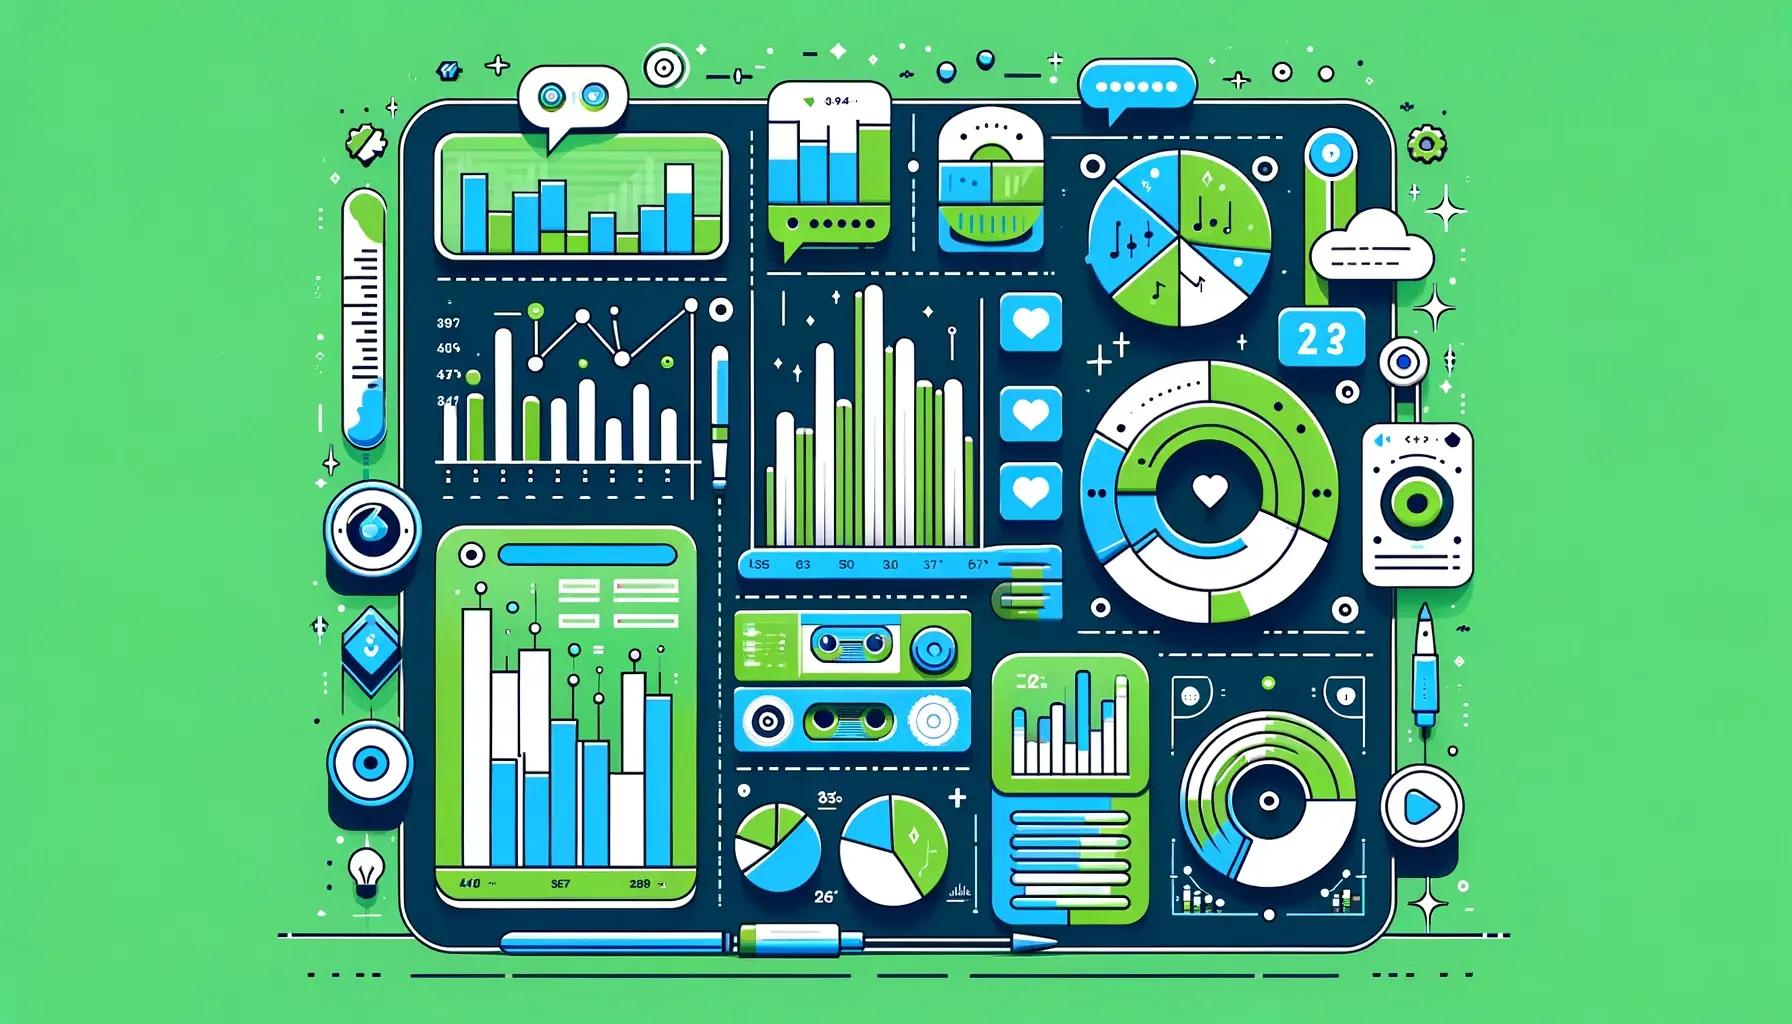

# Evaluating Retrieval Techniques for Semantic Similarity in Retrieval Augmented Generation

This exercise will focus on evulating the performance of different retrieval techniques for obtaining context for a user's query from an information repository such as the Wayfair WANDS Dataset. This dataset is a comprehensive listing of product descriptions matched to user inquiries. In this manner, we are able to score the results obtained from different semantic similarity techniques and evaluate them against one another. For this exercise, we chose several different techniques to compare. Those included BM25, TF-IDF, Cosine similarity, and Semantic Reranking.

In [ ]:
! pip install rank-bm25 torch transformers sentence-transformers fasttext faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nv

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import re
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
import os
import fasttext
from google.colab import files
import fasttext.util
import faiss
from google.colab import drive
drive.mount('/content/drive')
from numpy.linalg import norm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to get states from embedding model
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:

    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim = 1) / attention_mask.sum(dim = 1)[..., None]

# Function to lookup query matches
def get_exact_matches_for_(query):

    labels = label_df[label_df['query_id'] == query]

    return labels[labels['label'] == 'Exact']['product_id'].values

# Function to lookup query matches
def get_matches_for_(query):

    labels = label_df[label_df['query_id'] == query]

    return labels[labels['label'].isin(['Exact', 'Partial'])]['product_id'].values

# Function to get tf-idf results
def get_tfidf_products(x, n):

    return cosine_similarity(vec.transform([x]), matrix).flatten().argsort()[-n:][::-1]

#define functions for evaluating retrieval performance
def map_at_k(true_ids, predicted_ids, k = 10):

    """
    Calculate the Mean Average Precision at K (MAP@K).

    Parameters:
    true_ids (list): List of relevant product IDs.
    predicted_ids (list): List of predicted product IDs.
    k (int): Number of top elements to consider.
             NOTE: IF you wish to change top k, please provide a justification for choosing the new value

    Returns:
    float: MAP@K score.
    """
    #if either list is empty, return 0
    if not len(true_ids) or not len(predicted_ids):
        return 0.0

    score = 0.0
    num_hits = 0.0

    for i, p_id in enumerate(predicted_ids[:k]):

        if p_id in true_ids and p_id not in predicted_ids[:i]:

            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(true_ids), k)

# Function to execute bm search
def execute_bm_search(q):

    return np.argsort(bm25.get_scores(q.split(' ')))[-10:]

# Function to perform reranking
def execute_reranking(data, query):

    # Translate query
    query_embeddings = biencoder.encode(query, convert_to_tensor = True) #.cuda()

    # Get cosine similarity
    hits = util.semantic_search(query_embeddings, corpus_embeddings, top_k = topk)
    hits = hits[0]

    # Perform reranking
    cross_inp = [[query, data[hit['corpus_id']]] for hit in hits]
    cross_scores = crossencoderembeddingmodel.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):

        hits[idx]['score'] = cross_scores[idx]

    sortie = sorted(hits, key = lambda x: x['score'], reverse = True)[0:20]

    return [item['corpus_id'] for item in sortie]

In [ ]:
# Gather the data from Wayfair's github
!git clone https://github.com/wayfair/WANDS.git

Cloning into 'WANDS'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 7), reused 23 (delta 3), pack-reused 0
Receiving objects: 100% (40/40), 33.32 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
# Load the components
query_df = pd.read_csv("WANDS/dataset/query.csv", sep = '\t')
product_df = pd.read_csv("WANDS/dataset/product.csv", sep = '\t')
label_df = pd.read_csv("WANDS/dataset/label.csv", sep = '\t')

In [ ]:
query_df.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [ ]:
product_df.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [ ]:
label_df.head()

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact


In [ ]:
label_df['label'].value_counts()

label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64

In [ ]:
product_df.isnull().sum()

product_id                0
product_name              0
product_class          2852
category hierarchy     1556
product_description    6008
product_features          0
rating_count           9452
average_rating         9452
review_count           9452
dtype: int64

In [ ]:
# Combine fields and process text
product_df['text'] = product_df['product_name'] + ' ' + product_df['product_description'].fillna('')
product_df['text'] = product_df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
product_df['text'] = product_df['text'].apply(lambda x: re.sub('\d+', '', x).lower().strip().replace('  ', ' '))

In [ ]:
# Calculate TF-IDF
vec = TfidfVectorizer()
tfidf = vec.fit(product_df['text'])
matrix = tfidf.transform(product_df['text'])

In [ ]:
# Use the product ledger to calculate exact matches for each suggestion
query_df['matches'] = query_df['query_id'].apply(get_exact_matches_for_)
query_df['partial_matches'] = query_df['query_id'].apply(get_matches_for_)

In [ ]:
query_df['combos'] = query_df['query_id'].apply(get_matches_for_)

In [ ]:
# Use TF-IDF to calculate cosine similarity and return similar entries
query_df['suggestions'] = query_df['query'].apply(lambda x: get_tfidf_products(x, 20))

In [ ]:
# Calclate Mean Average Precision MAPE
query_df['score'] = query_df.apply(lambda x: map_at_k(x['matches'], x['suggestions'], k = 20), axis = 1)

In [ ]:
# BM25
bm25 = BM25Okapi(product_df['text'].apply(lambda x: x.split(' ')))

In [ ]:
# Add BM result to data
query_df['bm_suggestions'] = query_df['query'].apply(execute_bm_search)

In [ ]:
# Score BM25
query_df['bm_score'] = query_df.apply(lambda x: map_at_k(x['matches'], x['bm_suggestions'], k = 20), axis = 1)

In [ ]:
# Prepare an embedding model
queries = []
passages = []

for idx, row in query_df.iterrows():

    input = f"query: {row['query']}"
    queries.append(input)

for idx, row in product_df.iterrows():

    input = f"passage: {row['text']}"
    passages.append(input)

input_texts = queries + passages

In [ ]:
queries[:10]

['query: salon chair',
 'query: smart coffee table',
 'query: dinosaur',
 'query: turquoise pillows',
 'query: chair and a half recliner',
 'query: sofa with ottoman',
 'query: acrylic clear chair',
 'query: driftwood mirror',
 'query: home sweet home sign',
 'query: coffee table fire pit']

In [ ]:
len(queries)

480

In [ ]:
# Init model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
%time corpus_embeddings = embedder.encode(passages, convert_to_tensor = True)

CPU times: user 31.8 s, sys: 1.23 s, total: 33.1 s
Wall time: 16.2 s


In [ ]:
%time query_embeddings = embedder.encode(queries, convert_to_tensor = True)

CPU times: user 130 ms, sys: 5.45 ms, total: 135 ms
Wall time: 96.6 ms


In [ ]:
# Embed the products
corpus_embeddings = corpus_embeddings.to("cuda")
corpus_embeddings = util.normalize_embeddings(corpus_embeddings)

In [ ]:
# Embed the queries
query_embeddings = query_embeddings.to("cuda")
query_embeddings = util.normalize_embeddings(query_embeddings)

In [ ]:
# Comnpute cosine simi9larities
hits = util.semantic_search(query_embeddings, corpus_embeddings, score_function = util.dot_score, top_k = 20)

In [ ]:
hits[0]

[{'corpus_id': 7465, 'score': 0.7541677951812744},
 {'corpus_id': 33689, 'score': 0.7429395318031311},
 {'corpus_id': 40996, 'score': 0.7371828556060791},
 {'corpus_id': 25431, 'score': 0.7352950572967529},
 {'corpus_id': 33690, 'score': 0.7233843207359314},
 {'corpus_id': 33691, 'score': 0.7232967615127563},
 {'corpus_id': 20026, 'score': 0.7155030965805054},
 {'corpus_id': 25432, 'score': 0.6832795739173889},
 {'corpus_id': 40997, 'score': 0.6817553043365479},
 {'corpus_id': 6168, 'score': 0.6804269552230835},
 {'corpus_id': 6167, 'score': 0.6549874544143677},
 {'corpus_id': 18271, 'score': 0.6418010592460632},
 {'corpus_id': 24010, 'score': 0.6387490034103394},
 {'corpus_id': 25433, 'score': 0.6380845904350281},
 {'corpus_id': 2187, 'score': 0.6290384531021118},
 {'corpus_id': 7467, 'score': 0.6284823417663574},
 {'corpus_id': 7466, 'score': 0.6133460402488708},
 {'corpus_id': 25434, 'score': 0.6097074151039124},
 {'corpus_id': 24008, 'score': 0.6071467995643616},
 {'corpus_id': 240

In [ ]:
len(hits)

480

In [ ]:
# Extract a single instance for inspection
sims = [[y['corpus_id'] for y in x] for x in hits]

In [ ]:
sims[0]

[7465,
 33689,
 40996,
 25431,
 33690,
 33691,
 20026,
 25432,
 40997,
 6168,
 6167,
 18271,
 24010,
 25433,
 2187,
 7467,
 7466,
 25434,
 24008,
 24007]

In [ ]:
# Add the scores to the original data
query_df['semantic_suggestions'] = sims

In [ ]:
# Compute MAPE
query_df['semantic_score'] = query_df.apply(lambda x: map_at_k(x['matches'], x['semantic_suggestions'], k = 20), axis = 1)

In [ ]:
# Init model for reranking
biencoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
crossencoderembeddingmodel = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Set sequence length
biencoder.max_seq_length = 512

# Num docs
topk = 100

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Perform initial encoding
corpus_embeddings = biencoder.encode(product_df['text'], convert_to_tensor = True, show_progress_bar = True)
query_embeddings = biencoder.encode(query_df['query'].iloc[0], convert_to_tensor = True).cuda()

Batches:   0%|          | 0/1344 [00:00<?, ?it/s]

In [ ]:
# Extract 100 relevant passages for each query
hits = util.semantic_search(query_embeddings, corpus_embeddings, top_k = topk)
hits = hits[0]

In [ ]:
# Re-Rank the products
cross_inp = [[query_df['query'].iloc[0], product_df['text'][hit['corpus_id']]] for hit in hits]
cross_scores = crossencoderembeddingmodel.predict(cross_inp)

# Sort results by the cross-encoder scores
for idx in range(len(cross_scores)):

    hits[idx]['score'] = cross_scores[idx]

In [ ]:
# Examine outputs
print(f"Query Selection- {query_df['query'].iloc[0]}")

print("Top-3 Re-Ranked Hits")
hits = sorted(hits, key = lambda x: x['score'], reverse = True)

for hit in hits[0:3]:

    print("\t{:.3f}\t{}".format(hit['score'], product_df['product_name'][hit['corpus_id']].replace("\n", " ")))

Query Selection- salon chair
Top-3 Re-Ranked Hits
	8.191	barberpub salon massage chair
	8.156	hair salon chair
	7.957	reclining faux leather massage chair


In [ ]:
# Perform semantic reranking on the data
%time query_df['reranked'] = query_df['query'].apply(lambda x: execute_reranking(product_df['text'], x))

CPU times: user 51.1 s, sys: 1.95 s, total: 53.1 s
Wall time: 35.6 s


In [ ]:
query_df['reranking_score'] = query_df.apply(lambda x: map_at_k(x['matches'], x['reranked'], k = 20), axis = 1)

In [ ]:
for i in query_df.columns: print(i)

query_id
query
query_class
matches
partial_matches
combos
suggestions
score
bm_suggestions
bm_score
semantic_suggestions
semantic_score
reranked
reranking_score


In [ ]:
query_df.head()

,query_id,query,query_class,matches,partial_matches,combos,suggestions,score,bm_suggestions,bm_score,semantic_suggestions,semantic_score,reranked,reranking_score
0,0,salon chair,Massage Chairs,"[25434, 42931, 2636, 42923, 41156, 5936, 22390...","[25434, 42931, 2636, 42923, 41156, 5936, 22390...","[25434, 42931, 2636, 42923, 41156, 5936, 22390...","[7465, 7466, 33690, 7467, 33689, 15612, 33691,...",0.343828,"[20026, 25431, 33689, 33690, 33691, 7467, 7466...",0.253155,"[7465, 33689, 40996, 25431, 33690, 33691, 2002...",0.200846,"[25431, 7465, 7467, 24010, 7466, 25433, 24009,...",0.327142
1,1,smart coffee table,Coffee & Cocktail Tables,"[9929, 5235, 37304, 25973, 16679, 29449, 33698...","[38855, 9929, 5235, 26772, 3510, 39709, 39745,...","[38855, 9929, 5235, 26772, 3510, 39709, 39745,...","[33290, 8257, 19750, 37010, 28466, 15495, 2642...",0.000000,"[35972, 33562, 33563, 36315, 5929, 33698, 2033...",0.020833,"[41168, 33290, 8257, 294, 296, 2456, 19750, 39...",0.000000,"[33698, 24380, 13713, 38650, 34096, 38913, 405...",0.125000
2,2,dinosaur,Kids Wall Décor,"[4205, 4202, 4204, 36622, 29777, 40289, 10539,...","[4205, 4202, 4204, 36622, 29777, 40289, 10539,...","[4205, 4202, 4204, 36622, 29777, 40289, 10539,...","[24094, 34737, 195, 14418, 34735, 34736, 4202,...",1.000000,"[3754, 36630, 28472, 21048, 14418, 34736, 3473...",0.500000,"[4204, 4202, 38628, 4201, 4203, 195, 29886, 34...",0.911561,"[9569, 34737, 12130, 24094, 12179, 10553, 1055...",1.000000
3,3,turquoise pillows,Accent Pillows,"[18909, 12386, 12436, 32704, 12201, 18293, 404...","[32960, 18909, 12386, 12436, 32704, 42718, 427...","[32960, 18909, 12386, 12436, 32704, 42718, 427...","[23599, 12436, 21028, 10537, 4676, 7965, 21037...",0.147222,"[11792, 4673, 21253, 4676, 7964, 10537, 17920,...",0.032361,"[5998, 12436, 21244, 27814, 21239, 21250, 1220...",0.277212,"[5998, 12436, 21244, 23599, 19100, 13577, 2123...",0.355495
4,4,chair and a half recliner,Recliners,"[5488, 6098, 42393, 16598, 41662, 40331, 24881...","[10957, 24866, 24867, 24869, 5488, 6098, 38471...","[10957, 24866, 24867, 24869, 5488, 6098, 38471...","[34103, 2185, 1526, 16208, 23171, 24147, 24174...",0.000000,"[35369, 32081, 31460, 18971, 13159, 26054, 152...",0.000000,"[24174, 7785, 16208, 26878, 29228, 31339, 2287...",0.000000,"[5492, 2287, 2845, 41955, 29759, 31142, 30300,...",0.000000


In [ ]:
#fasttext.util.download_model('en', if_exists = 'ignore')

In [ ]:
#ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
os.listdir('drive/MyDrive')

['Colab Notebooks', 'archive', 'models', 'docs', 'crawl-300d-2M-subword.bin']

In [ ]:
query_df.columns

Index(['query_id', 'query', 'query_class', 'matches', 'partial_matches',
       'combos', 'suggestions', 'score', 'bm_suggestions', 'bm_score',
       'semantic_suggestions', 'semantic_score', 'reranked',
       'reranking_score'],
      dtype='object')

In [ ]:
# Load vectors from drive
ft = fasttext.load_model('drive/MyDrive/crawl-300d-2M-subword.bin')

In [ ]:
# Create a list of vectors from the fastText model
product_df['ft_vectors'] = product_df['text'].apply(lambda x: ft.get_sentence_vector(x))

In [ ]:
# Compute the fasttext vectors for the queries as well
query_df['ft_vectors'] = query_df['query'].apply(lambda x: ft.get_sentence_vector(x))

In [ ]:
len(product_df['ft_vectors'].iloc[0])

300

In [ ]:
queries = [i for i in query_df['ft_vectors']]
products = [i for i in product_df['ft_vectors']]

In [ ]:
selections = []

for outputs in cosine_similarity(queries, products):

    selection = outputs.flatten().argsort()[-10:][::-1]
    selections.append(selection)

In [ ]:
len(selections[0])

10

In [ ]:
query_df.columns

Index(['query_id', 'query', 'query_class', 'matches', 'partial_matches',
       'combos', 'suggestions', 'score', 'bm_suggestions', 'bm_score',
       'semantic_suggestions', 'semantic_score', 'reranked', 'reranking_score',
       'ft_vectors'],
      dtype='object')

In [ ]:
# Compute similarity results using fasttext cosine
query_df['ft_suggestions'] = selections
query_df['ft_score'] = query_df.apply(lambda x: map_at_k(x['matches'], x['ft_suggestions'], k = 20), axis = 1)

In [ ]:
print('Semantic Scoring Results- MAPE scores:')
print(f"TF-IDF on the Queries was {round(query_df.loc[:, 'score'].mean(), 3)}")
print(f"BM25 on the Queries was {round(np.mean(query_df['bm_score']), 3)}")
print(f"Cosine similarity of the embeddings on the Queries was {round(query_df.loc[:, 'semantic_score'].mean(), 3)}")
print(f"Semantic ReRanking on the Queries was {round(query_df.loc[:, 'reranking_score'].mean(), 3)}")
print(f"FastText Search on the Queries was {round(query_df.loc[:, 'ft_score'].mean(), 3)}")
print()
print('Scores for Expanded Search to Include Partial Matches: ')
print(f"TF-IDF:         {round(np.mean(query_df.apply(lambda x: map_at_k(x['partial_matches'], x['suggestions'], k = 20), axis = 1)), 3)}")
print(f"BM25:           {round(np.mean(query_df.apply(lambda x: map_at_k(x['partial_matches'], x['bm_suggestions'], k = 20), axis = 1)), 3)}")
print(f"all-MiniLM:     {round(np.mean(query_df.apply(lambda x: map_at_k(x['partial_matches'], x['semantic_suggestions'], k = 20), axis = 1)), 3)}")
print(f"ms-MarcoMiniLM: {round(np.mean(query_df.apply(lambda x: map_at_k(x['partial_matches'], x['reranked'], k = 20), axis = 1)), 3)}")
print(f"FastText:       {round(np.mean(query_df.apply(lambda x: map_at_k(x['partial_matches'], x['ft_suggestions'], k = 20), axis = 1)), 3)}")

Semantic Scoring Results- MAPE scores:
TF-IDF on the Queries was 0.257
BM25 on the Queries was 0.146
Cosine similarity of the embeddings on the Queries was 0.307
Semantic ReRanking on the Queries was 0.413
FastText Search on the Queries was 0.104

Scores for Expanded Search to Include Partial Matches: 
TF-IDF:         0.608
BM25:           0.325
all-MiniLM:     0.677
ms-MarcoMiniLM: 0.732
FastText:       0.287
